<a href="https://colab.research.google.com/github/surekhasunkara/Complete-Python-3-Bootcamp/blob/master/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install lightning

# Getting Started

In this assignment you will be implementing at least 2 unique models and working with both the CIFAR10 and Imagenette datasets. The cell below defines a basic model based on the examples we reviewed in class. You should use this as a starting point to implement your own models.

You should have no problems running this notebook in Google Colab. If you choose to run it on your own machine, a yaml file is provided with the necessary dependencies. If you are using anaconda, you can create a new environment with the following command:

```bash
conda env create -f env.yml
```

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torchvision.datasets import Imagenette
from torchvision.datasets import CIFAR10
import torch.optim as optim
import pytorch_lightning as pl
import matplotlib.pyplot as plt


In [5]:
class SimpleCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_loss = 0
        self.val_loss = 0

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        self.train_loss = loss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", self.accuracy)
        self.val_loss = loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", self.accuracy)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [6]:
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Imagenette
train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)

# Use 10% of the training set for validation
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

# Use DataLoader to load the dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=16, shuffle=False)

# Configure the test dataset
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)

100%|██████████| 99.0M/99.0M [00:02<00:00, 42.0MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 99.0M/99.0M [00:02<00:00, 41.4MB/s]


In [7]:
model1 = SimpleCNN()
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min",
                             dirpath='my/path/',
    filename='model1-{epoch:02d}',
    save_top_k=1)
trainer = L.Trainer(max_epochs=50, callbacks=[early_stop, checkpoint])
trainer.fit(model1, train_loader, val_loader)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 92.7 K | train
1 | fc_layers   | Sequential         | 2.1 M  | train
2 | accuracy    | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.771     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode
INFO: 
  | Name        | Type           

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [8]:
print(f"Model Training loss {model1.train_loss}, Validation loss {model1.val_loss}")

Model Training loss 0.19957876205444336, Validation loss 1.5868111848831177


In [9]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=16, shuffle=False)
trainer.test(model1, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5694267749786377     │
│         test_loss         │    1.9915623664855957     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.9915623664855957, 'test_accuracy': 0.5694267749786377}]

# **ResNet 10 Model**

In [10]:
class ResNet18Classifier(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # adjust for grayscale
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_loss = 0
        self.val_loss = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        self.train_losss = loss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", self.accuracy)
        self.val_loss = loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", self.accuracy)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [11]:
model2 = ResNet18Classifier()
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=8)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min",
                             dirpath='my/path/',
    filename='model2-{epoch:02d}',
    save_top_k=3)
trainer = L.Trainer(max_epochs=50, callbacks=[early_stop, checkpoint])
trainer.fit(model2, train_loader, val_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/my/path exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [12]:
print(f"Model Training loss {model2.train_loss}, Validation loss {model2.val_loss}")

Model Training loss 0, Validation loss 1.9418721199035645


In [13]:
trainer.test(model2, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6109554171562195     │
│         test_loss         │    2.0073060989379883     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.0073060989379883, 'test_accuracy': 0.6109554171562195}]

# **ResNet 10 with Regularization (dropout)**

In [14]:
class ResNet18Augmented(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # adjust for grayscale
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_loss = 0
        self.val_loss = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        self.train_loss = loss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_accuracy", self.accuracy)
        self.val_loss = loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", self.accuracy)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [15]:
model3 = ResNet18Augmented()
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=10)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min",
                             dirpath='my/path/',
    filename='model3-{epoch:02d}',
    save_top_k=3)

In [16]:
trainer = L.Trainer(max_epochs=50, callbacks=[early_stop, checkpoint])
trainer.fit(model3, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode
INFO: 
  | Name     | Type               | Params | Mode 
---------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
print(f"Model Training loss {model3.train_loss}, Validation loss {model3.val_loss}")

Model Training loss 0.12735188007354736, Validation loss 2.0262458324432373


In [18]:
trainer.test(model3, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5510827898979187     │
│         test_loss         │     2.537923574447632     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.537923574447632, 'test_accuracy': 0.5510827898979187}]

# **Transfer Learning**

In [19]:
class TransferResNet18(L.LightningModule):
    def __init__(self, num_classes=10, pretrained_model_path=None):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        if pretrained_model_path:
            self.model = models.resnet18(weights=Imagenette)
            self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_losses = []
        self.validation_losses = []
        self.train_loss = 0
        self.val_loss = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        self.train_loss = loss
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.validation_losses.append(loss.item())
        self.log("val_loss", loss)
        self.log("val_accuracy", self.accuracy)
        self.val_loss = loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.accuracy.update(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", self.accuracy)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def plot_losses(self):
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.validation_losses, label='Validation Loss')
        plt.xlabel('Batch')
        plt.ylabel('Loss')
        plt.title('Loss Curves')
        plt.legend()
        plt.grid(True)
        plt.show()

In [20]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [21]:
dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transforms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8)
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **ResNet Model on CIFAR10 Dataset (Not - PreTrained )**

In [22]:
model_scratch = TransferResNet18()
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min",
                             dirpath='my/path/',
    filename='model4-{epoch:02d}',
    save_top_k=3)
trainer = L.Trainer(max_epochs=50, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5), checkpoint])
trainer.fit(model_scratch, train_loader, val_loader)
trainer.test(model_scratch, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode
INFO: 
  | Name     | Type               | Params | Mode 
---------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7297000288963318     │
│         test_loss         │    0.9969472885131836     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9969472885131836, 'test_accuracy': 0.7297000288963318}]

In [23]:
print(f"Model Training loss {model_scratch.train_loss}, Validation loss {model_scratch.val_loss}")

Model Training loss 0.23129042983055115, Validation loss 0.6471432447433472


# **ResNet Model on CIFAR10 Dataset (With Imagenet weights)**

In [24]:
pretrained_path = "/content/my/path/model-epoch=02.ckpt"
model_pretrained = TransferResNet18(pretrained_model_path=pretrained_path)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min",
                             dirpath='my/path/',
    filename='model5-{epoch:02d}',
    save_top_k=1)
trainer = L.Trainer(max_epochs=50, callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5), checkpoint])
trainer.fit(model_pretrained, train_loader, val_loader)
trainer.test(model_pretrained, test_loader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_D

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7303000092506409     │
│         test_loss         │    1.0710203647613525     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0710203647613525, 'test_accuracy': 0.7303000092506409}]

In [25]:
print(f"Model Training loss {model_pretrained.train_loss}, Validation loss {model_pretrained.val_loss}")

Model Training loss 0.2468881607055664, Validation loss 1.2846242189407349


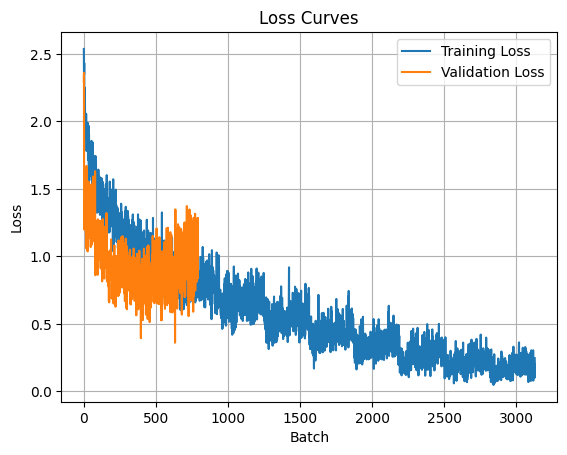

In [26]:
model_pretrained.plot_losses()